In [1]:
import numpy as np 
import h5py
import os
import matplotlib.pyplot as plt
import pickle

In [2]:
from Utilz.losses import re_im_sep_vectors, re_im_combined
from Utilz.training import load_model_params

In [3]:
file_idx = 91
sample_idx = 0

Functions to load the data

In [5]:
data_dir = "/mnt/oneterra/SFG_reIm_h5/"

crystal_length = 100

with open(os.path.join(data_dir, "scaler.pkl"), "rb") as file:  # can use scaler.pkl or scaler_bckkup.pkl
    scaler = pickle.load(file)

def get_file_x_sample_y(file_index, sample_indexes, get_crystal = True):
    crystal_output_data = None
    input_data_list = []
    slice_data_list = []
    with h5py.File(os.path.join(data_dir, "X_new_data.h5"), "r") as file:
        x_dataset = file[f"dataset_{file_index}"]
        x_dataset = x_dataset[:]
        for idx in sample_indexes:
            input_data_list.append(x_dataset[idx])

    with h5py.File(os.path.join(data_dir, "y_new_data.h5"), "r") as file:
        y_dataset = file[f"dataset_{file_index}"]
        for idx in sample_indexes:
            slice_data_list.append(y_dataset[idx])
        if get_crystal:
            y_dataset = y_dataset[crystal_length - 1 :][::crystal_length]
            crystal_output_data = y_dataset[sample_indexes[0]]

    return np.array(input_data_list), np.array(slice_data_list), crystal_output_data

/opt/conda/envs/pytorch/lib/python3.10/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 0.23.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Loading a bunch of data

In [6]:
input_data, slice_output_data, _ = get_file_x_sample_y(file_idx, range(sample_idx, sample_idx + 10, 1))

In [12]:
input_data[0][0]

array([0.44133613, 0.69610655, 0.39261723, ..., 0.4885948 , 0.4884149 ,
       0.5052599 ], dtype=float32)

In [14]:
input_data[1][-1]

array([0.5291946 , 0.6647621 , 0.33095235, ..., 0.48834723, 0.488186  ,
       0.5049894 ], dtype=float32)

In [16]:
slice_output_data[0]

array([0.5291946 , 0.6647621 , 0.33095235, ..., 0.48834723, 0.488186  ,
       0.5049894 ], dtype=float32)

In [ ]:
model_dir = "/mnt/oneterra/outputs/06-12-2023/"
model_save_name = "LSTM_100_epoch_66"

with h5py.File(os.path.join(model_dir, f"{model_save_name}_all_preds.h5"), "r") as file:
    model_preds = file[f"dataset_{file_idx}"]
    model_preds_loaded = model_preds[:]
    model_preds_item = model_preds[sample_idx]

In [10]:
import torch
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(
        self,
        input_size: int,
        lstm_hidden_size: int = 1024,
        linear_layer_size: int = 4096,
        num_layers: int = 1,
        **kwargs,
    ):
        super().__init__()
        self.input_size = input_size
        self.num_layers = num_layers
        self.hidden_size = lstm_hidden_size
        self.lstm = nn.LSTM(
            input_size,
            lstm_hidden_size,
            batch_first=True,
            dropout=0,
            num_layers=num_layers,
        )
        self.linear = nn.Sequential(
            nn.Linear(lstm_hidden_size, linear_layer_size),
            nn.ReLU(),
            nn.Linear(linear_layer_size, linear_layer_size),
            nn.Tanh(),
            nn.Linear(linear_layer_size, input_size),
            nn.Sigmoid(),
        )

        print(f"hidden_size: {lstm_hidden_size}, linear size: {linear_layer_size}, n_layers: {num_layers}")

    def forward(
        self, x: torch.Tensor, h_0: torch.Tensor = None, c_0: torch.Tensor = None
    ):
        # hidden state
        if h_0 is None:
            h_0 = torch.zeros(self.num_layers * 1, x.size(0), self.hidden_size).to(
                x.device
            )
        # cell state
        if c_0 is None:
            c_0 = torch.zeros(self.num_layers * 1, x.size(0), self.hidden_size).to(
                x.device
            )

        out_1, (hn, cn) = self.lstm(x, (h_0, c_0))
        out = self.linear(out_1[:, -1, :])

        return out

In [13]:
model = LSTMModel(8264, 2048)
model, _ = load_model_params(model, os.path.join(model_dir, f"{model_save_name}.pth"), "cpu")

hidden_size: 2048, linear size: 4096, n_layers: 1
Loading pre-trained model parameters from /mnt/oneterra/outputs/06-12-2023/LSTM_100_epoch_66.pth


In [14]:
model_slice_output = model(torch.tensor(input_data).unsqueeze(0).float()).detach().numpy()

In [15]:
input_data.shape, slice_output_data.shape, crystal_output_data.shape, model_preds_item.shape, model_slice_output.shape

((10, 8264), (8264,), (8264,), (8264,), (1, 8264))

In [5]:
input_data.shape

(10, 8264)

In [6]:
y_dataset.shape

(100, 8264)

In [9]:
model_preds_loaded.shape, model_preds_item.shape

((100, 8264), (8264,))

In [10]:
type(input_data), type(crystal_output_data), type(slice_output_data)

(numpy.ndarray, numpy.ndarray, numpy.ndarray)

In [17]:
# add fake batch dimension to crystal_output_data
crystal_output_data = np.expand_dims(crystal_output_data, axis=0)
slice_output_data = np.expand_dims(slice_output_data, axis=0)
model_pred_data = np.expand_dims(model_preds_item, axis=0)

In [19]:
# do the inverse scaling
input_data = scaler.inverse_transform(input_data)
slice_output_data = scaler.inverse_transform(slice_output_data)
crystal_output_data = scaler.inverse_transform(crystal_output_data)
model_pred_data = scaler.inverse_transform(model_pred_data)

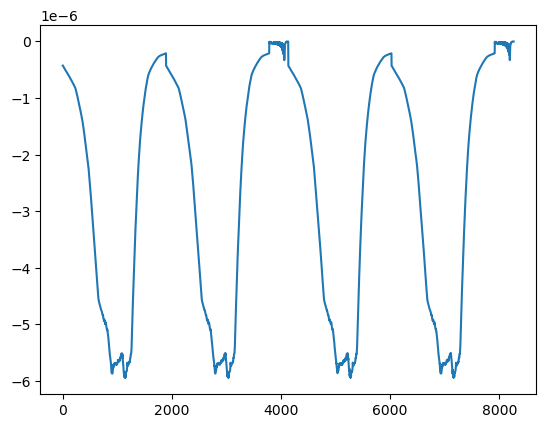

In [23]:
test = scaler.inverse_transform(input_data[0:1,:])
plt.plot(test[0,:])

In [12]:
crystal_output_data.shape, slice_output_data.shape

((1, 8264), (1, 8264))

In [18]:
input_shg1_real, input_shg1_complex, input_shg2_real, input_shg2_complex, input_sfg_real, input_sfg_complex = re_im_sep_vectors(input_data)
slice_output_shg1_real, slice_output_shg1_complex, slice_output_shg2_real, slice_output_shg2_complex, slice_output_sfg_real, slice_output_sfg_complex = re_im_sep_vectors(slice_output_data)
crystal_output_shg1_real, crystal_output_shg1_complex, crystal_output_shg2_real, crystal_output_shg2_complex, crystal_output_sfg_real, crystal_output_sfg_complex = re_im_sep_vectors(crystal_output_data)
model_output_shg1_real, model_output_shg1_complex, model_output_shg2_real, model_output_shg2_complex, model_output_sfg_real, model_output_sfg_complex = re_im_sep_vectors(model_pred_data)
model_slice_output_shg1_real, model_slice_output_shg1_complex, model_slice_output_shg2_real, model_slice_output_shg2_complex, model_slice_output_sfg_real, model_slice_output_sfg_complex = re_im_sep_vectors(model_slice_output)

# for all of them, get the last index
input_shg1_real = input_shg1_real[-1]
input_shg1_complex = input_shg1_complex[-1]
input_shg2_real = input_shg2_real[-1]
input_shg2_complex = input_shg2_complex[-1]
input_sfg_real = input_sfg_real[-1]
input_sfg_complex = input_sfg_complex[-1]

slice_output_shg1_real = slice_output_shg1_real[-1]
slice_output_shg1_complex = slice_output_shg1_complex[-1]
slice_output_shg2_real = slice_output_shg2_real[-1]
slice_output_shg2_complex = slice_output_shg2_complex[-1]
slice_output_sfg_real = slice_output_sfg_real[-1]
slice_output_sfg_complex = slice_output_sfg_complex[-1]

crystal_output_shg1_real = crystal_output_shg1_real[-1]
crystal_output_shg1_complex = crystal_output_shg1_complex[-1]
crystal_output_shg2_real = crystal_output_shg2_real[-1]
crystal_output_shg2_complex = crystal_output_shg2_complex[-1]
crystal_output_sfg_real = crystal_output_sfg_real[-1]
crystal_output_sfg_complex = crystal_output_sfg_complex[-1]

model_output_shg1_real = model_output_shg1_real[-1]
model_output_shg1_complex = model_output_shg1_complex[-1]
model_output_shg2_real = model_output_shg2_real[-1]
model_output_shg2_complex = model_output_shg2_complex[-1]
model_output_sfg_real = model_output_sfg_real[-1]
model_output_sfg_complex = model_output_sfg_complex[-1]

model_slice_output_shg1_real = model_slice_output_shg1_real[-1]
model_slice_output_shg1_complex = model_slice_output_shg1_complex[-1]
model_slice_output_shg2_real = model_slice_output_shg2_real[-1]
model_slice_output_shg2_complex = model_slice_output_shg2_complex[-1]
model_slice_output_sfg_real = model_slice_output_sfg_real[-1]
model_slice_output_sfg_complex = model_slice_output_sfg_complex[-1]

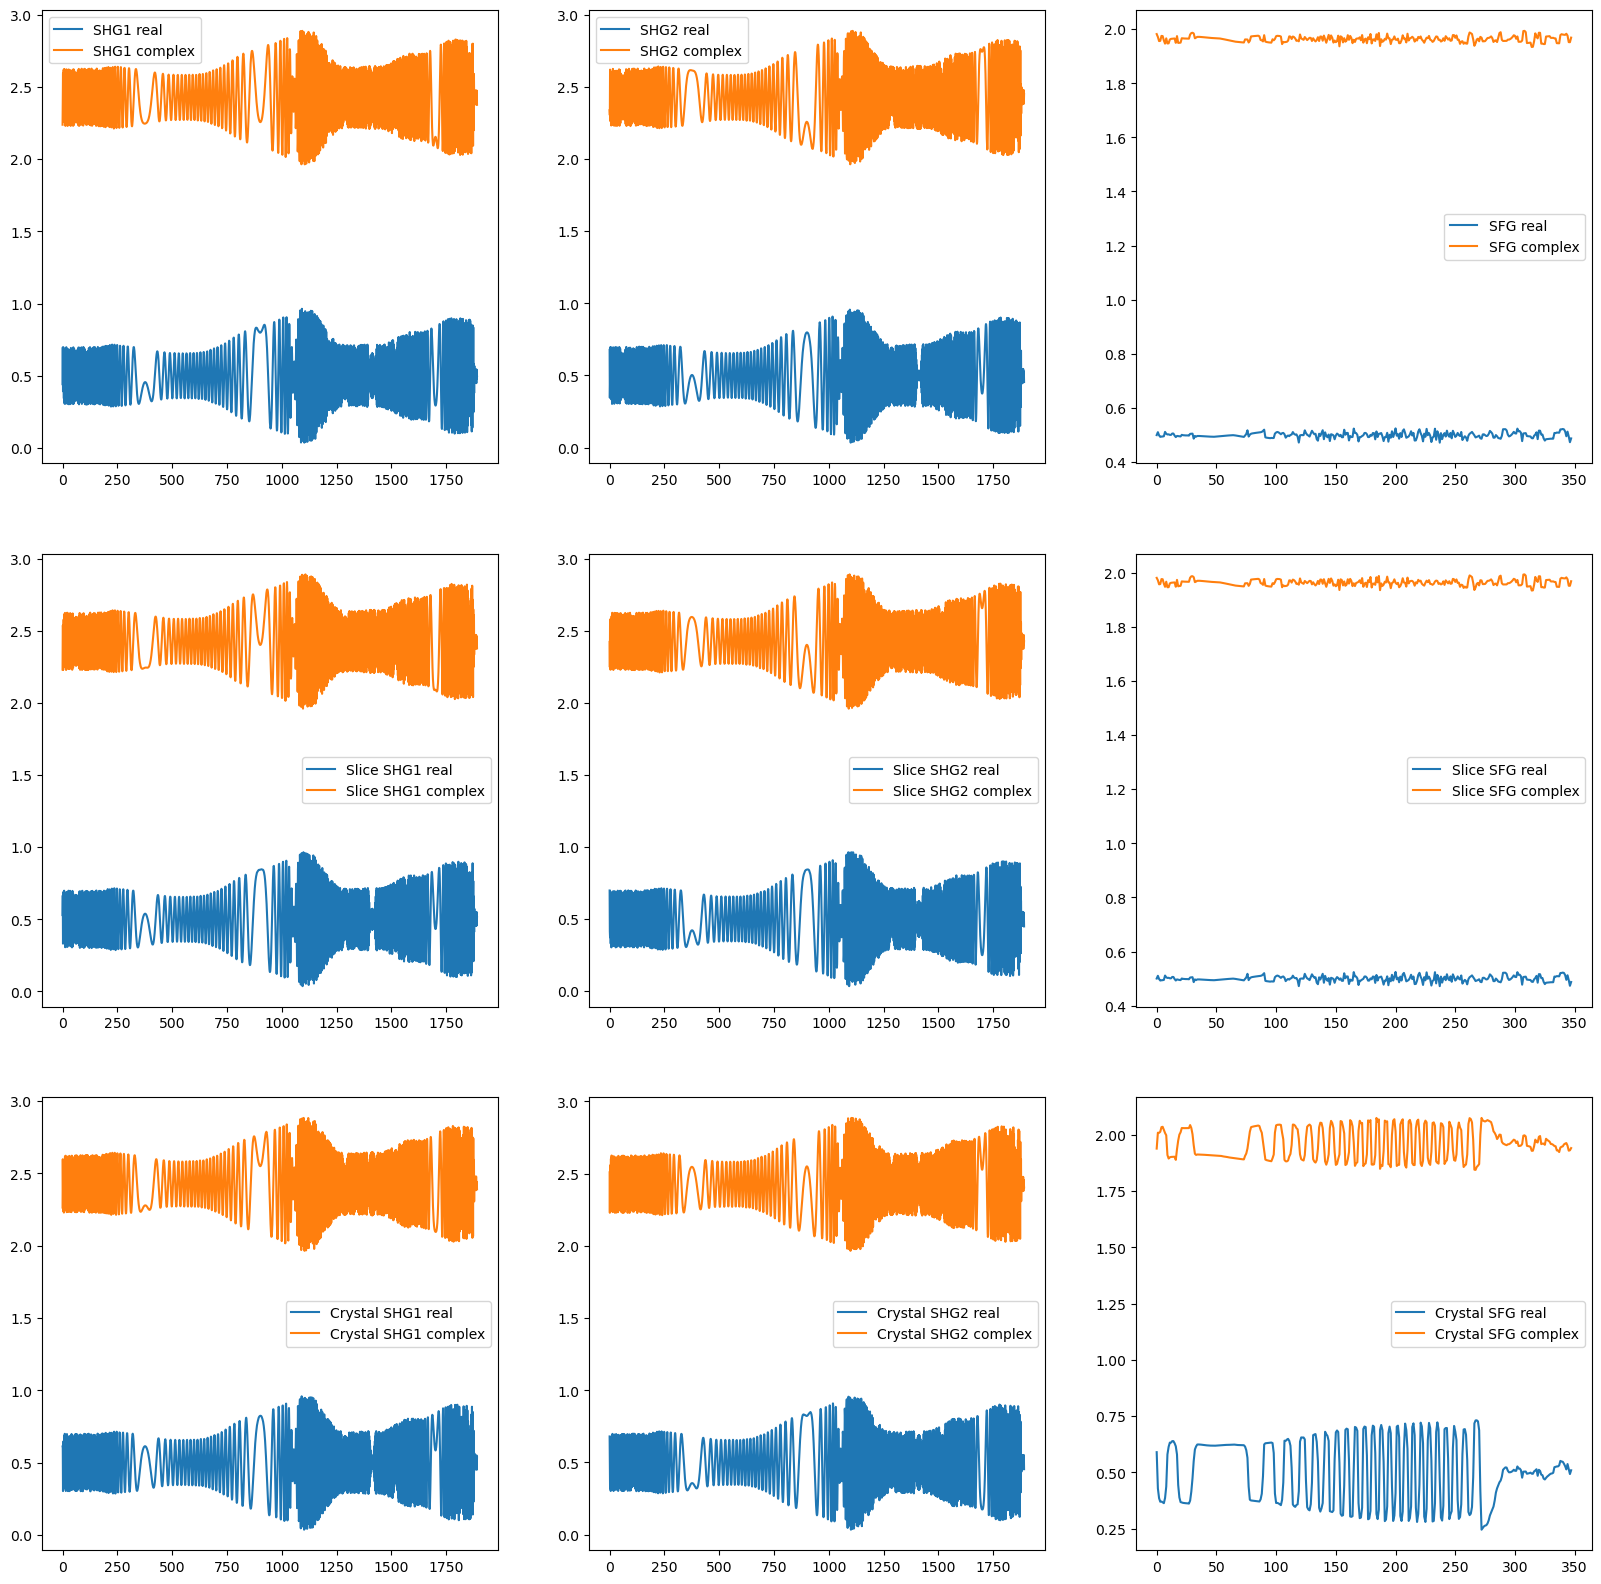

In [6]:
shg_offset = 2* np.max(input_shg1_real) #* 1e-6
sfg_offset = 2 * np.max(crystal_output_sfg_real) #* 1e-6

# plot each signal separately
fig, ax = plt.subplots(3, 3, figsize=(20, 20))
ax[0, 0].plot(input_shg1_real, label="SHG1 real")
ax[0, 0].plot(input_shg1_complex + shg_offset, label="SHG1 complex")
ax[0, 0].legend()

ax[0,1].plot(input_shg2_real, label="SHG2 real")
ax[0, 1].plot(input_shg2_complex + shg_offset, label="SHG2 complex")
ax[0, 1].legend()

ax[0, 2].plot(input_sfg_real, label="SFG real")
ax[0, 2].plot(input_sfg_complex + sfg_offset, label="SFG complex")
ax[0, 2].legend()

ax[1, 0].plot(slice_output_shg1_real, label="Slice SHG1 real")
ax[1, 0].plot(slice_output_shg1_complex + shg_offset, label="Slice SHG1 complex")
ax[1, 0].legend()

ax[1, 1].plot(slice_output_shg2_real, label="Slice SHG2 real")
ax[1, 1].plot(slice_output_shg2_complex + shg_offset, label="Slice SHG2 complex")
ax[1, 1].legend()

ax[1, 2].plot(slice_output_sfg_real, label="Slice SFG real")
ax[1, 2].plot(slice_output_sfg_complex + sfg_offset, label="Slice SFG complex")
ax[1, 2].legend()

ax[2, 0].plot(crystal_output_shg1_real, label="Crystal SHG1 real")
ax[2, 0].plot(crystal_output_shg1_complex + shg_offset, label="Crystal SHG1 complex")
ax[2, 0].legend()

ax[2, 1].plot(crystal_output_shg2_real, label="Crystal SHG2 real")
ax[2, 1].plot(crystal_output_shg2_complex + shg_offset, label="Crystal SHG2 complex")
ax[2, 1].legend()

ax[2, 2].plot(crystal_output_sfg_real, label="Crystal SFG real")
ax[2, 2].plot(crystal_output_sfg_complex + sfg_offset, label="Crystal SFG complex")
ax[2, 2].legend()

# plt.show()

plt.savefig("re_im_sep.png")


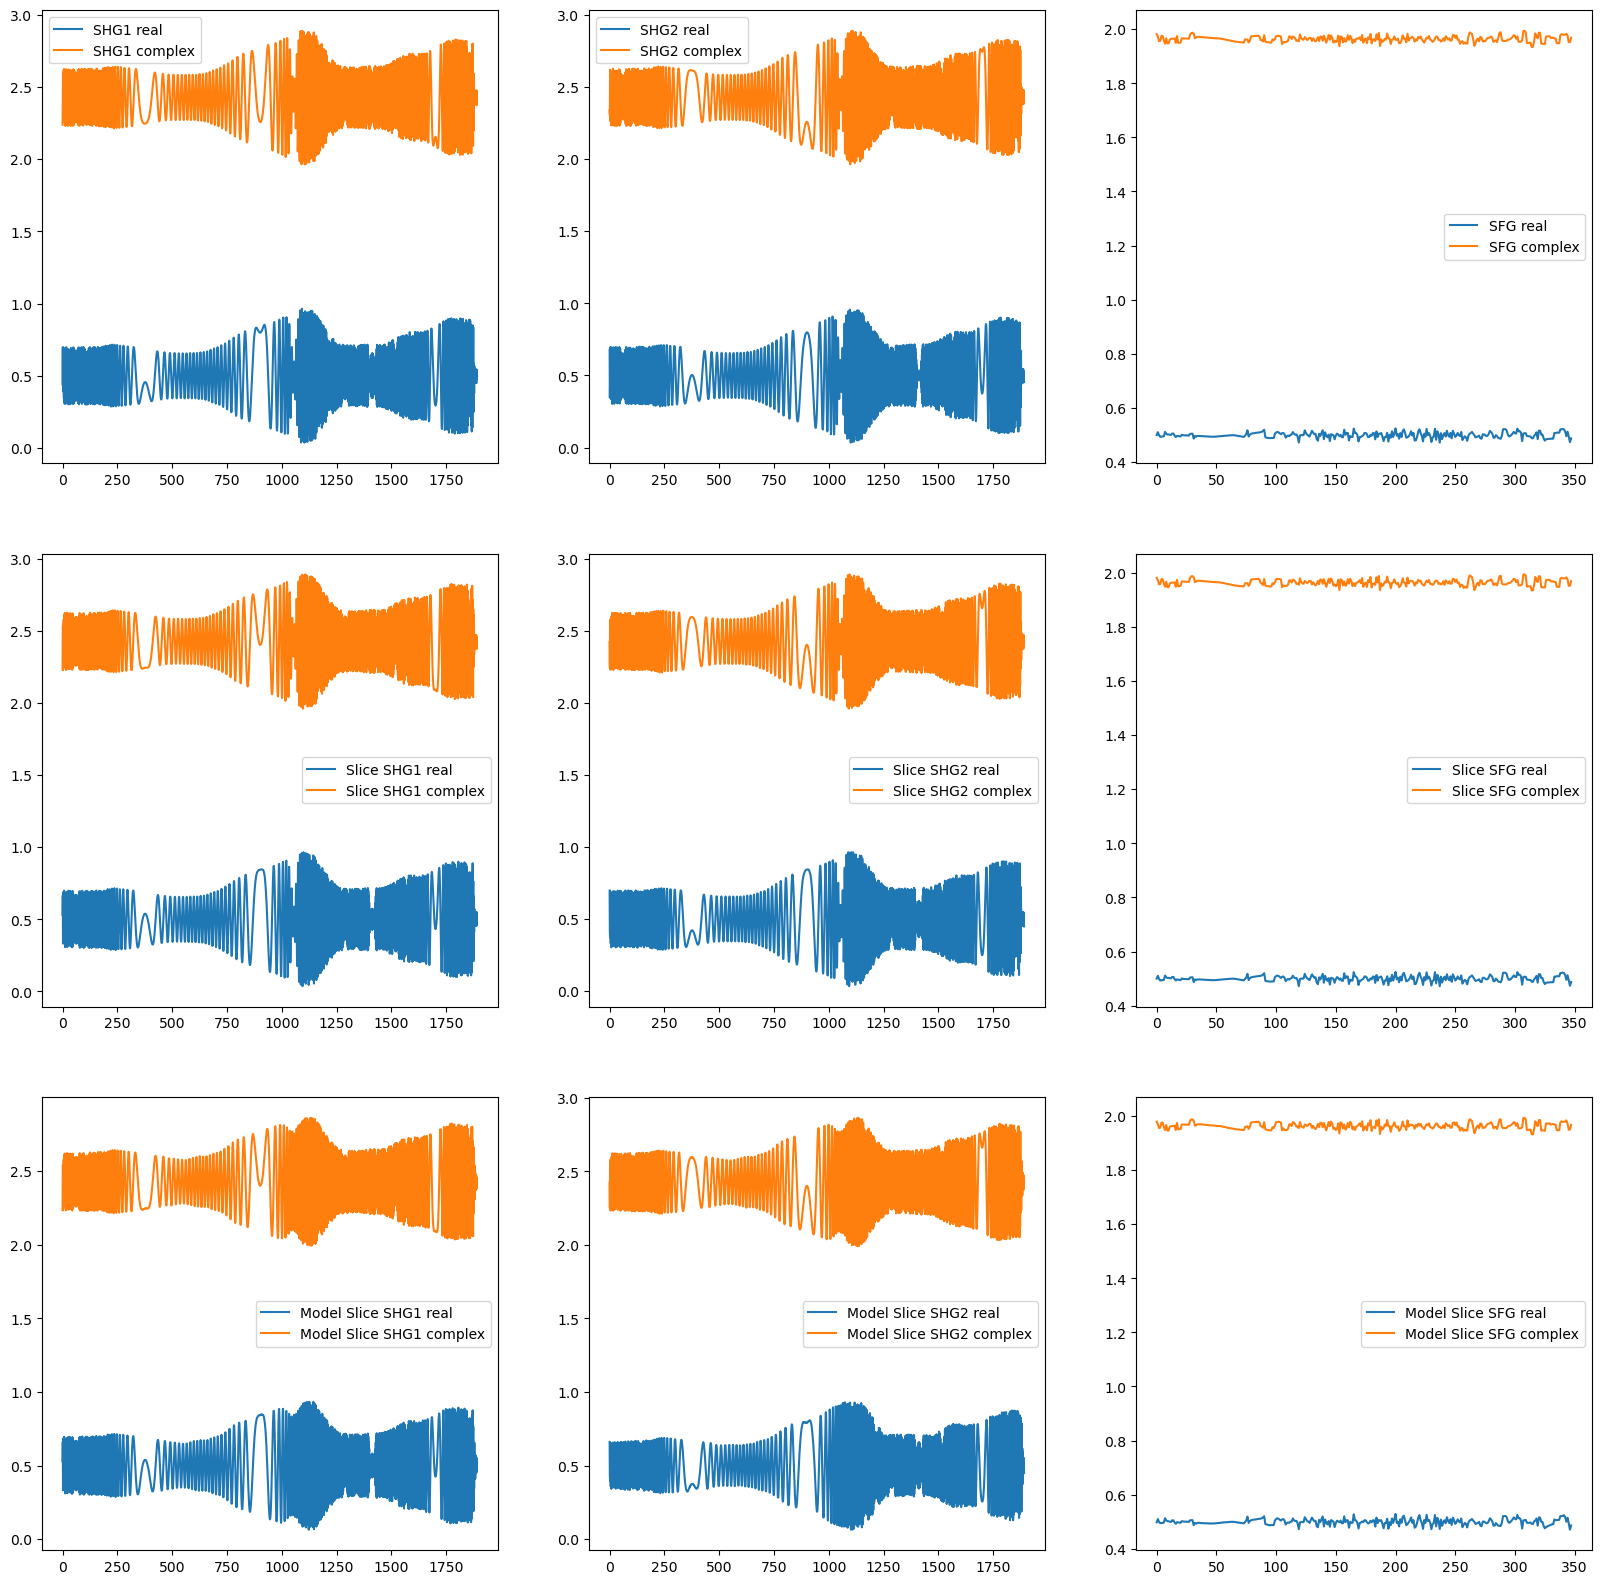

In [19]:
shg_offset = 2* np.max(input_shg1_real) #* 1e-6
sfg_offset = 2 * np.max(crystal_output_sfg_real) #* 1e-6

# plot each signal separately
fig, ax = plt.subplots(3, 3, figsize=(20, 20))
ax[0, 0].plot(input_shg1_real, label="SHG1 real")
ax[0, 0].plot(input_shg1_complex + shg_offset, label="SHG1 complex")
ax[0, 0].legend()

ax[0,1].plot(input_shg2_real, label="SHG2 real")
ax[0, 1].plot(input_shg2_complex + shg_offset, label="SHG2 complex")
ax[0, 1].legend()

ax[0, 2].plot(input_sfg_real, label="SFG real")
ax[0, 2].plot(input_sfg_complex + sfg_offset, label="SFG complex")
ax[0, 2].legend()

ax[1, 0].plot(slice_output_shg1_real, label="Slice SHG1 real")
ax[1, 0].plot(slice_output_shg1_complex + shg_offset, label="Slice SHG1 complex")
ax[1, 0].legend()

ax[1, 1].plot(slice_output_shg2_real, label="Slice SHG2 real")
ax[1, 1].plot(slice_output_shg2_complex + shg_offset, label="Slice SHG2 complex")
ax[1, 1].legend()

ax[1, 2].plot(slice_output_sfg_real, label="Slice SFG real")
ax[1, 2].plot(slice_output_sfg_complex + sfg_offset, label="Slice SFG complex")
ax[1, 2].legend()

ax[2, 0].plot(model_slice_output_shg1_real, label="Model Slice SHG1 real")
ax[2, 0].plot(model_slice_output_shg1_complex + shg_offset, label="Model Slice SHG1 complex")
ax[2, 0].legend()

ax[2, 1].plot(model_output_shg2_real, label="Model Slice SHG2 real")
ax[2, 1].plot(model_slice_output_shg2_complex + shg_offset, label="Model Slice SHG2 complex")
ax[2, 1].legend()

ax[2, 2].plot(model_slice_output_sfg_real, label="Model Slice SFG real")
ax[2, 2].plot(model_slice_output_sfg_complex + sfg_offset, label="Model Slice SFG complex")
ax[2, 2].legend()

# plt.show()

plt.savefig("re_im_sep.png")


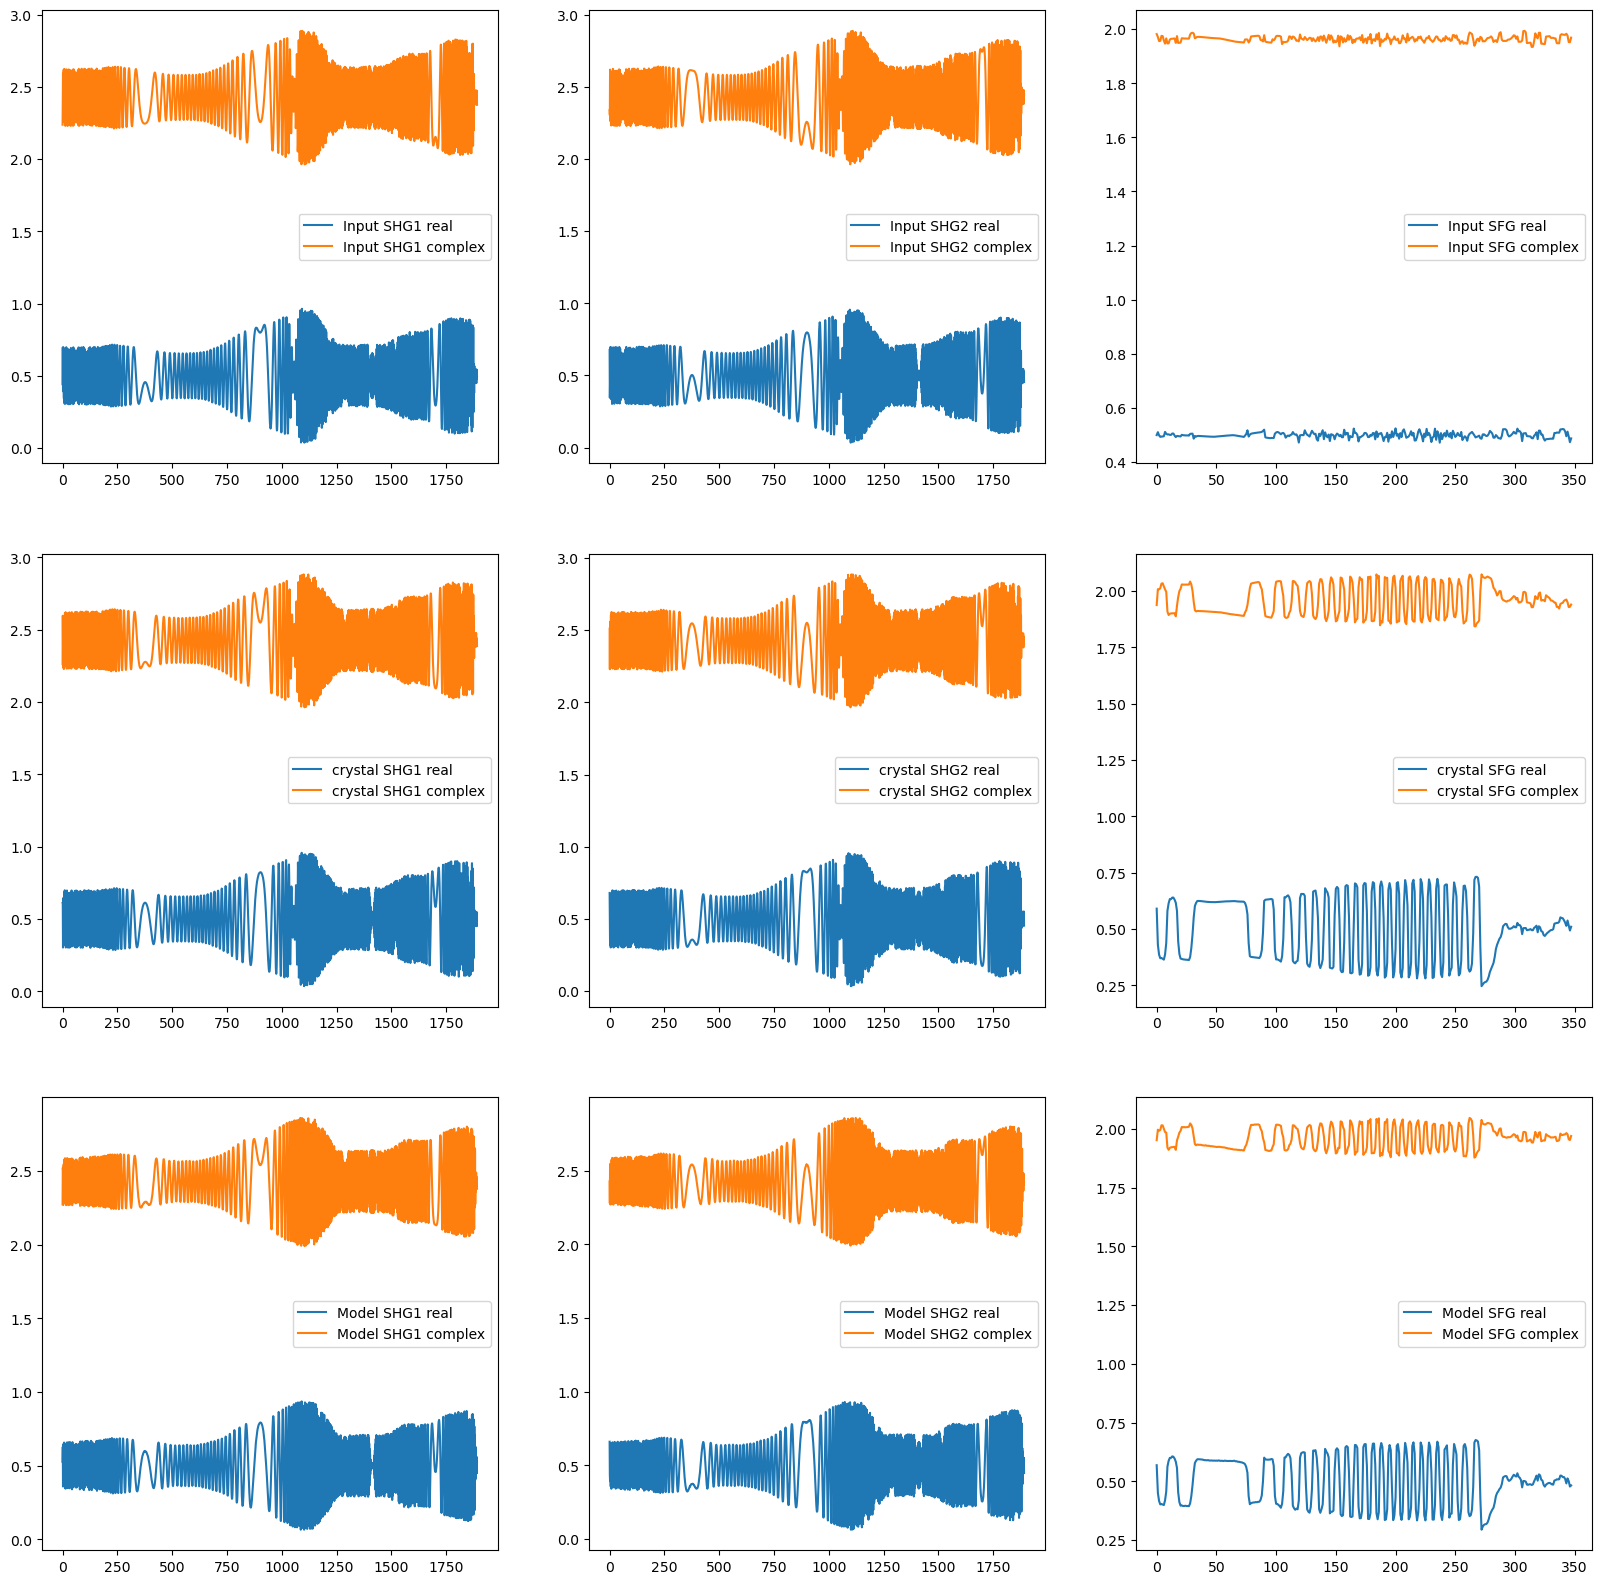

In [7]:
# shg_offset = 1
# sfg_offset = 0.25

# plot each signal separately
fig, ax = plt.subplots(3, 3, figsize=(20, 20))
ax[0, 0].plot(input_shg1_real, label="Input SHG1 real")
ax[0, 0].plot(input_shg1_complex + shg_offset, label="Input SHG1 complex")
ax[0, 0].legend()

ax[0,1].plot(input_shg2_real, label="Input SHG2 real")
ax[0, 1].plot(input_shg2_complex + shg_offset, label="Input SHG2 complex")
ax[0, 1].legend()

ax[0, 2].plot(input_sfg_real, label="Input SFG real")
ax[0, 2].plot(input_sfg_complex + sfg_offset, label="Input SFG complex")
ax[0, 2].legend()

ax[1, 0].plot(crystal_output_shg1_real, label="crystal SHG1 real")
ax[1, 0].plot(crystal_output_shg1_complex + shg_offset, label="crystal SHG1 complex")
ax[1, 0].legend()

ax[1, 1].plot(crystal_output_shg2_real, label="crystal SHG2 real")
ax[1, 1].plot(crystal_output_shg2_complex + shg_offset, label="crystal SHG2 complex")
ax[1, 1].legend()

ax[1, 2].plot(crystal_output_sfg_real, label="crystal SFG real")
ax[1, 2].plot(crystal_output_sfg_complex + sfg_offset, label="crystal SFG complex")
ax[1, 2].legend()

ax[2, 0].plot(model_output_shg1_real, label="Model SHG1 real")
ax[2, 0].plot(model_output_shg1_complex + shg_offset, label="Model SHG1 complex")
ax[2, 0].legend()

ax[2, 1].plot(model_output_shg2_real, label="Model SHG2 real")
ax[2, 1].plot(model_output_shg2_complex + shg_offset, label="Model SHG2 complex")
ax[2, 1].legend()

ax[2, 2].plot(model_output_sfg_real, label="Model SFG real")
ax[2, 2].plot(model_output_sfg_complex + sfg_offset, label="Model SFG complex")
ax[2, 2].legend()

# plt.show()

plt.savefig("re_im_sep_2.png")

In [21]:
from Analysis.analyze_reim import do_analysis

/opt/conda/envs/pytorch/lib/python3.10/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 0.23.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


direct, and resampled energies:  4.573751708183228e-13 4.573751708183231e-13
direct, and resampled energies:  2.5592849552087175e-13 2.559284955208717e-13
direct, and resampled energies:  2.5177723732331748e-05 2.5177723732331758e-05
direct, and resampled energies:  2.5000000978410462e-05 2.5000000978410462e-05
direct, and resampled energies:  2.517708957442301e-05 2.5177089574423016e-05
direct, and resampled energies:  2.5000000978410462e-05 2.500000097841046e-05
Normalized plots
------- True vs Prediction Frequency Domain --------
*** SFG ***
*** SHG1 ***
*** SHG2 ***
------- True vs Prediction Time Domain --------
*** SFG ***
*** SHG1 ***
*** SHG2 ***


<Figure size 640x480 with 0 Axes>

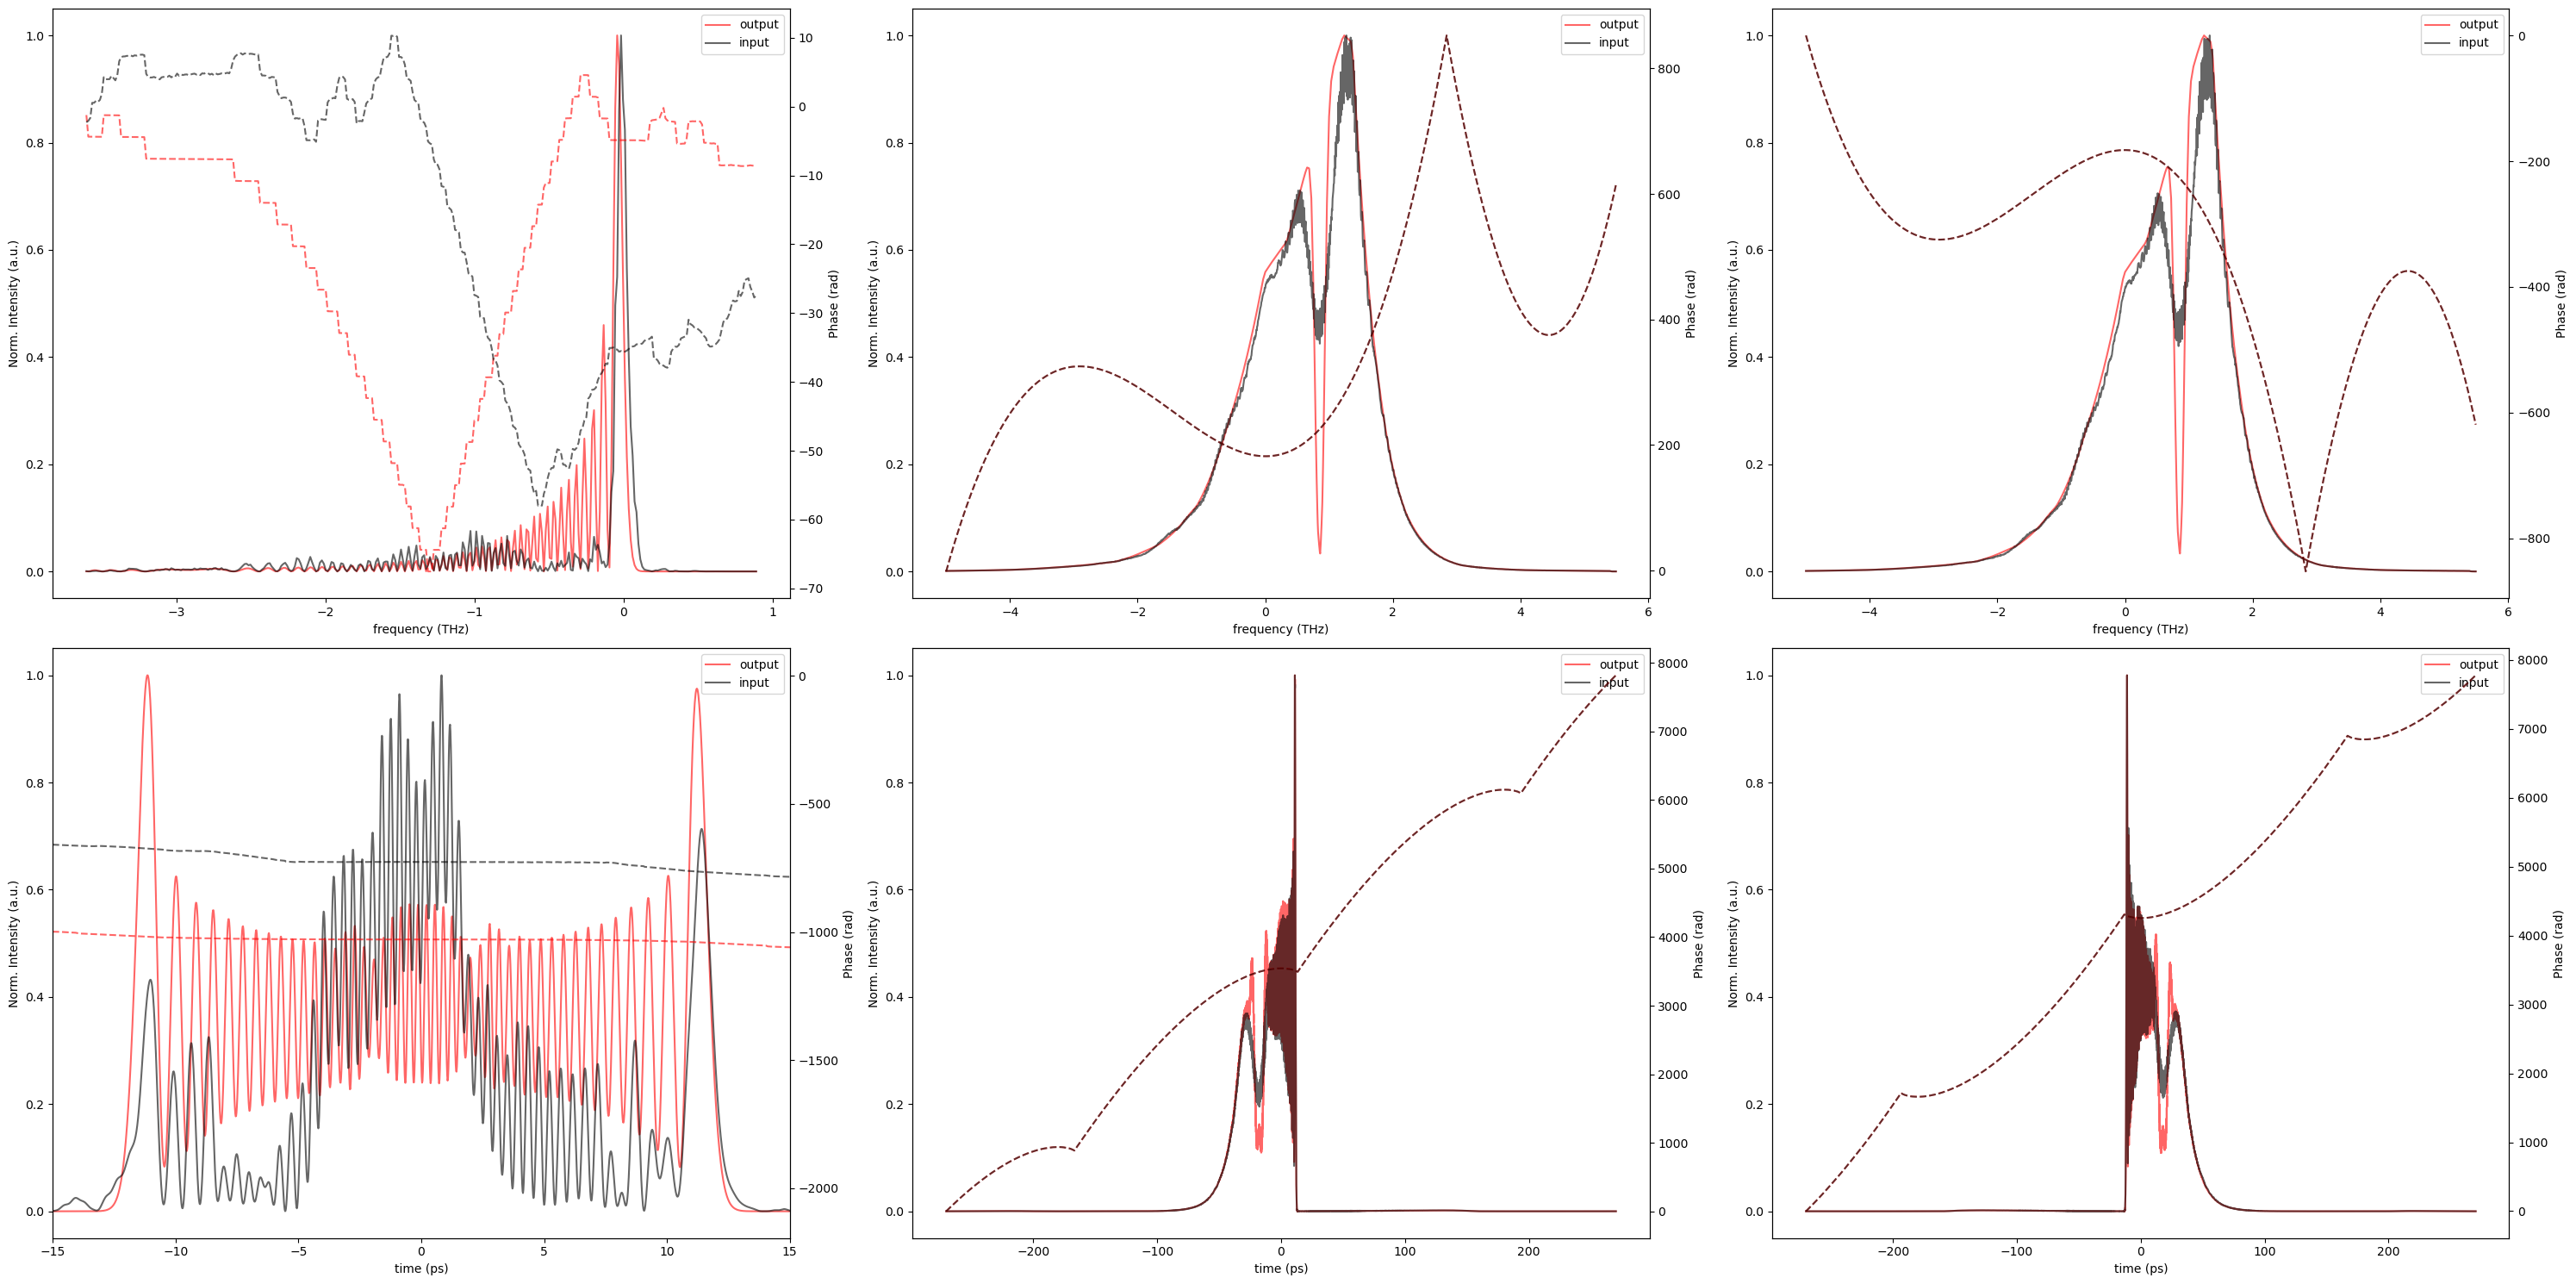

Original plots
------- True vs Prediction Frequency Domain --------
*** SFG ***
*** SHG1 ***
*** SHG2 ***
------- True vs Prediction Time Domain --------
*** SFG ***
*** SHG1 ***
*** SHG2 ***


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

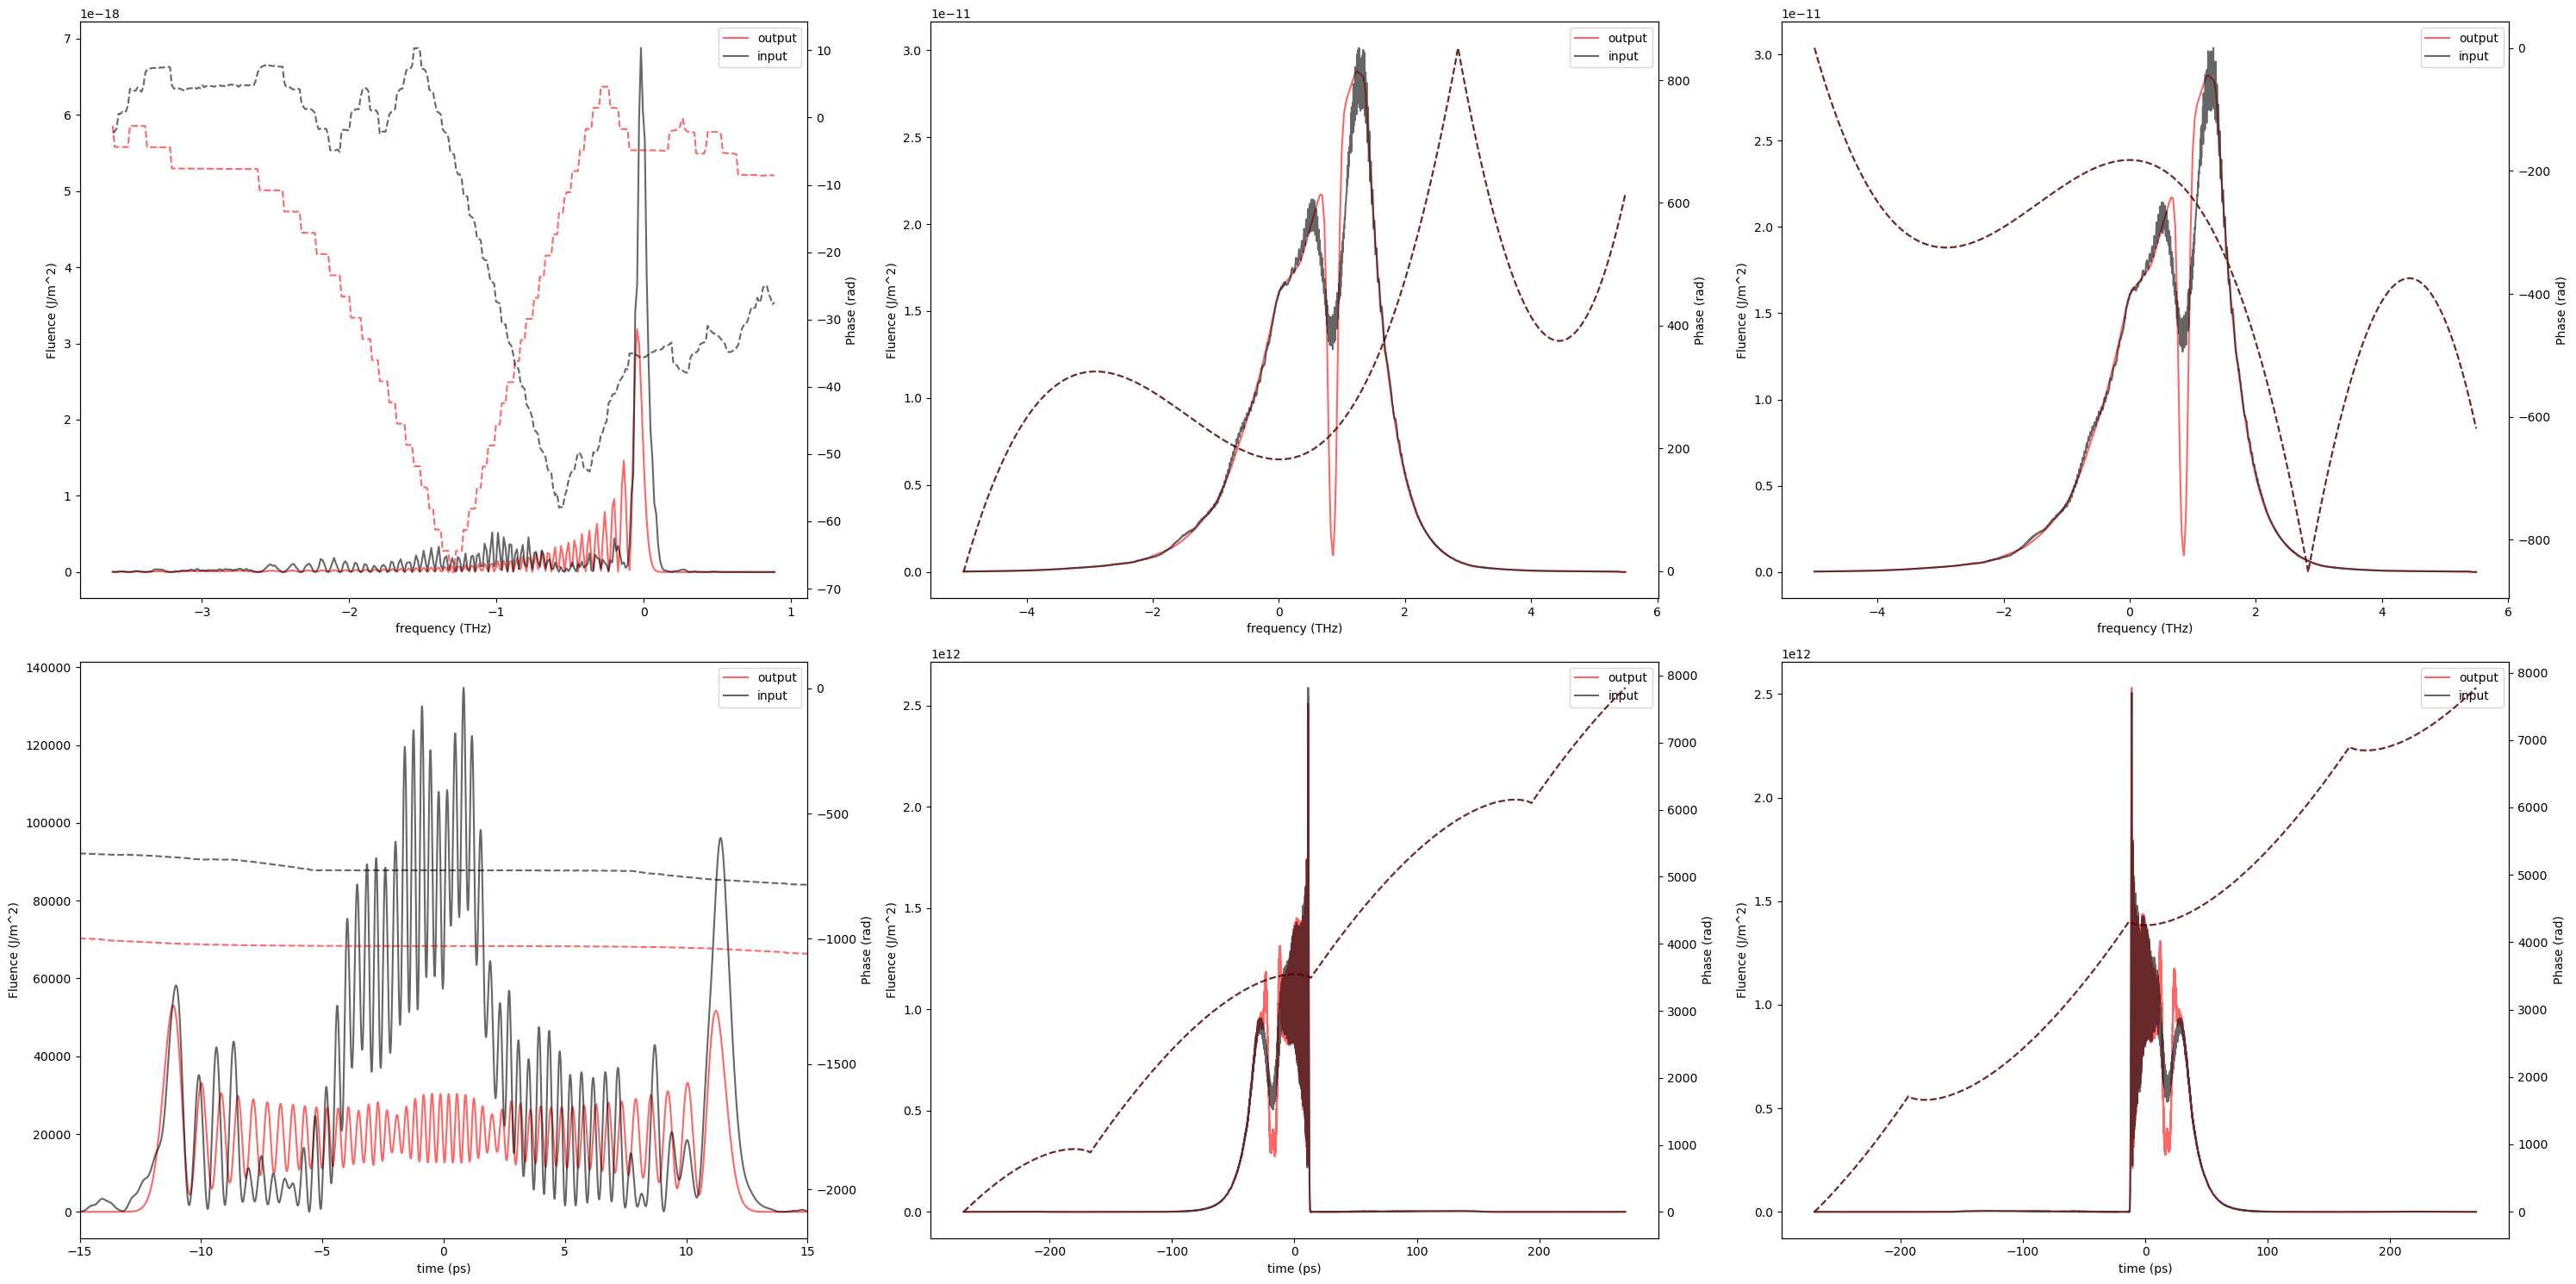

<Figure size 640x480 with 0 Axes>

In [22]:
do_analysis(".", data_dir, "blah", file_idx, sample_idx, ".", crystal_length, y_true_trans_item=slice_output_data[-1], y_pred_trans_item=model_slice_output[-1], labels_list=["output", "input"])

In [ ]:
do_analysis(".", data_dir, "blah", file_idx, sample_idx, ".", crystal_length, y_pred_trans_item=input_data[0], labels_list=["output", "input"])

/opt/conda/envs/pytorch/lib/python3.10/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 0.23.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


direct, and resampled energies:  1.3411739545123609e-09 1.3411739545123607e-09
direct, and resampled energies:  2.3770820489533887e-09 2.3770820489533883e-09
direct, and resampled energies:  2.3161165989236347e-05 2.3161165989236344e-05
direct, and resampled energies:  2.4998811932331603e-05 2.4998811932331593e-05
direct, and resampled energies:  2.3170229988408374e-05 2.3170229988408374e-05
direct, and resampled energies:  2.4998809455152266e-05 2.499880945515227e-05
Normalized plots
------- True vs Prediction Frequency Domain --------
*** SFG ***
*** SHG1 ***
*** SHG2 ***
------- True vs Prediction Time Domain --------
*** SFG ***
*** SHG1 ***
*** SHG2 ***


<Figure size 640x480 with 0 Axes>

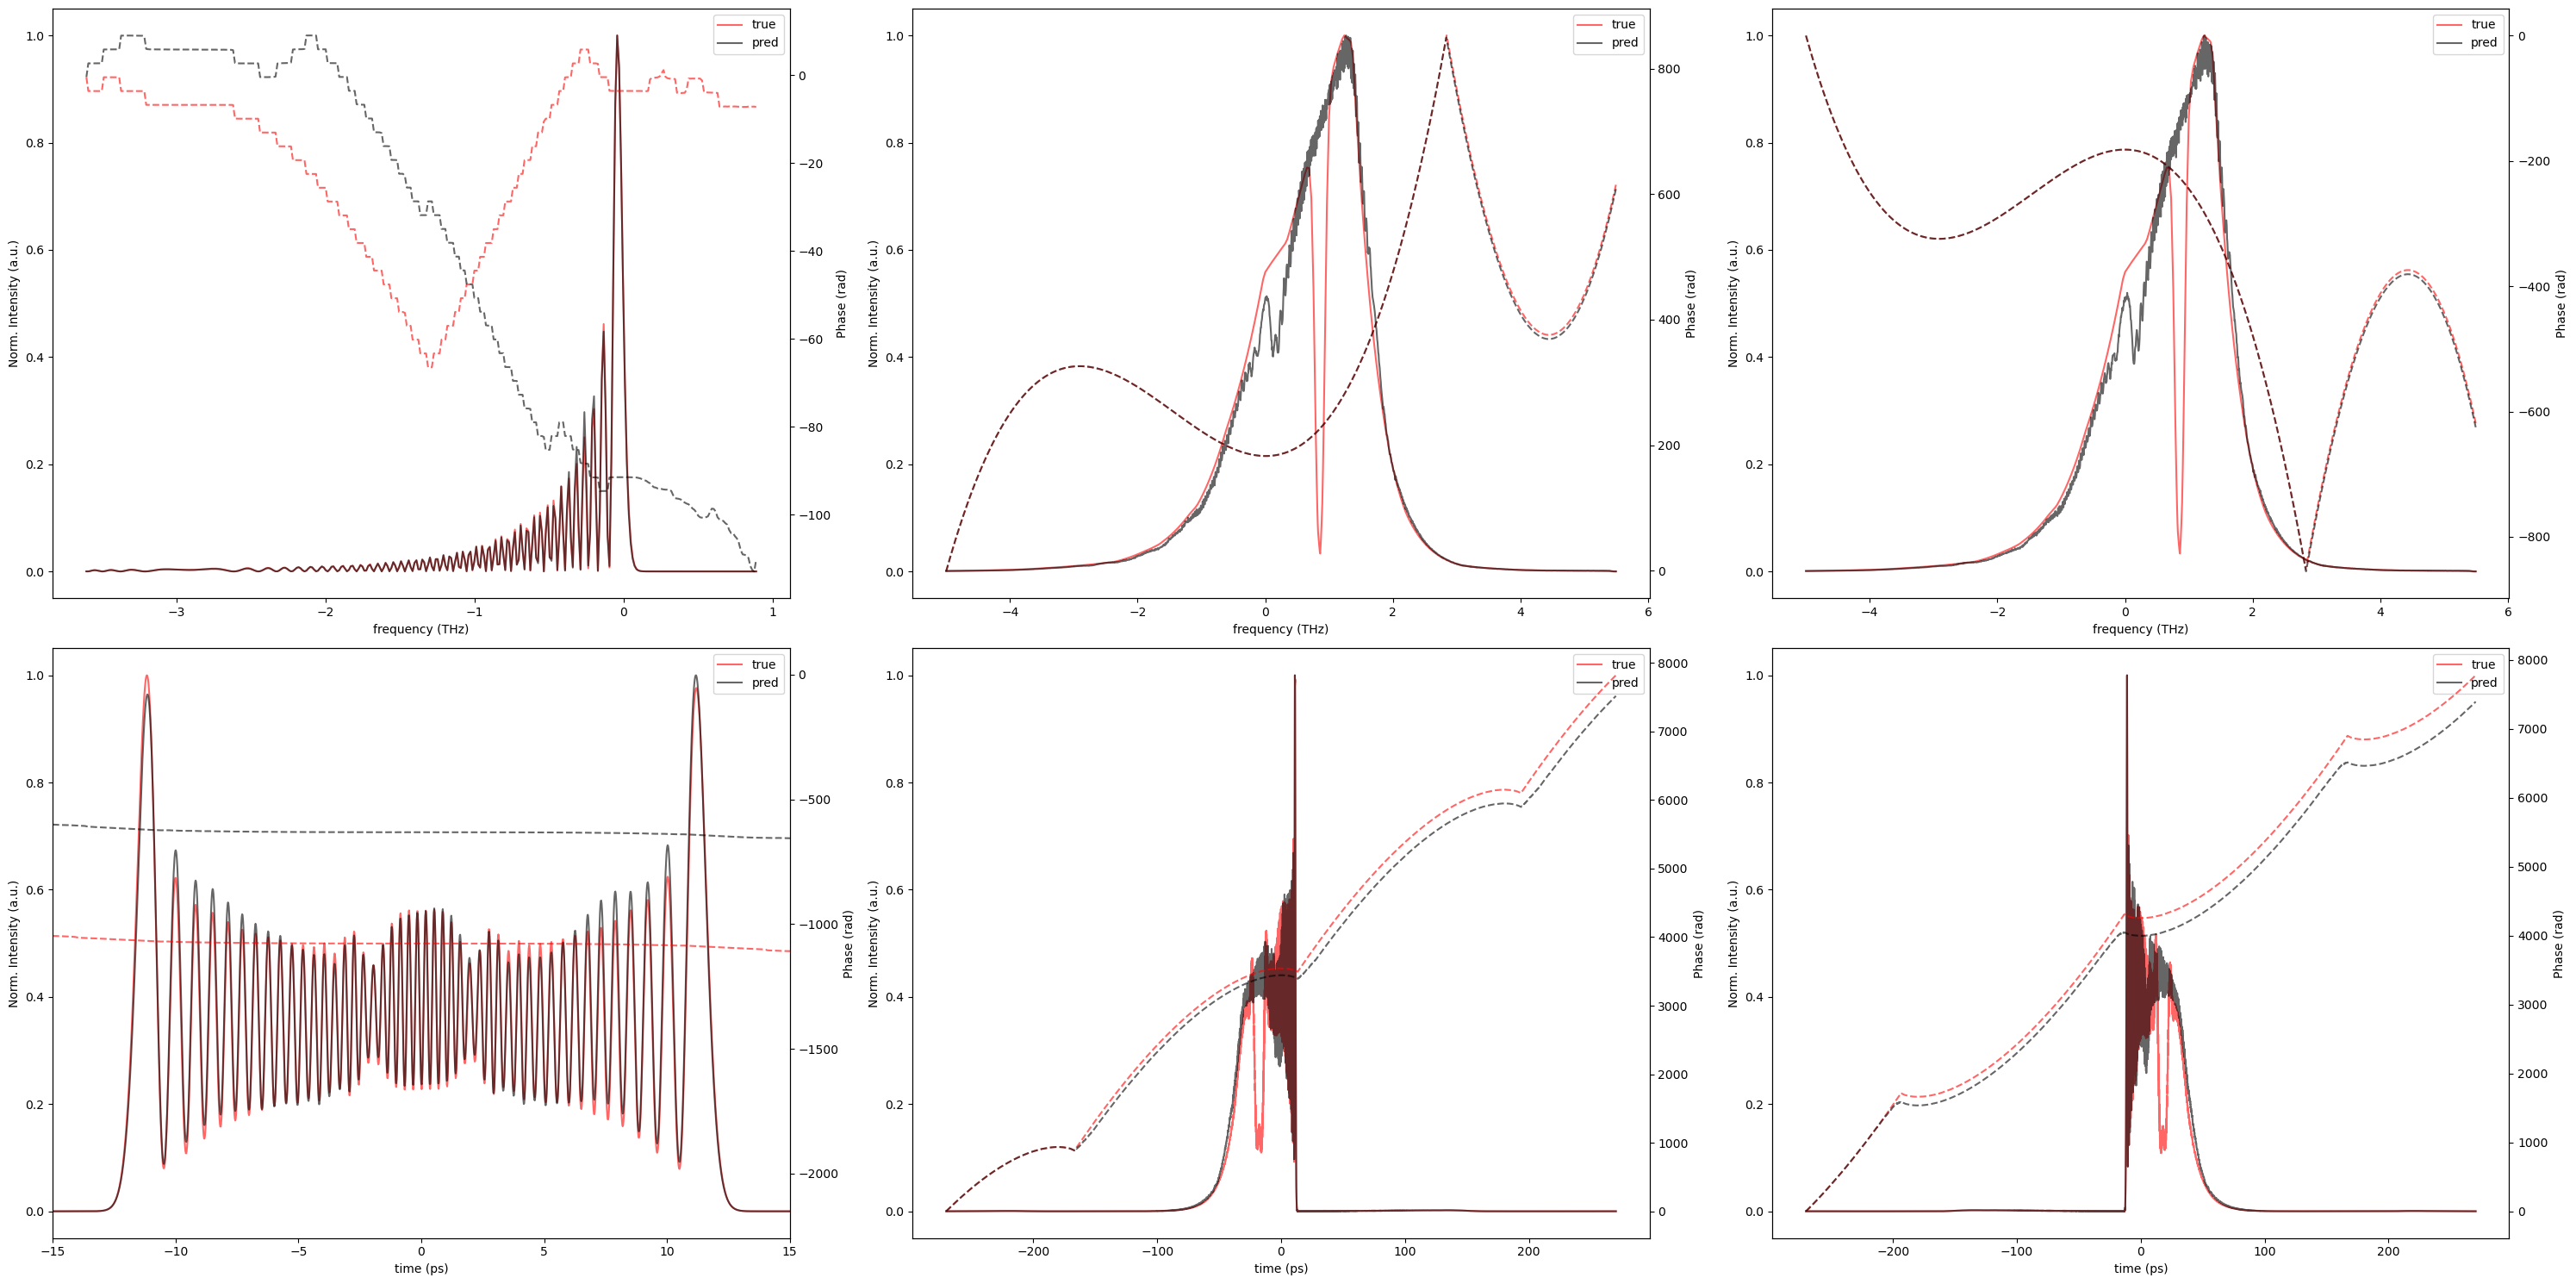

Original plots
------- True vs Prediction Frequency Domain --------
*** SFG ***
*** SHG1 ***
*** SHG2 ***
------- True vs Prediction Time Domain --------
*** SFG ***
*** SHG1 ***
*** SHG2 ***


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

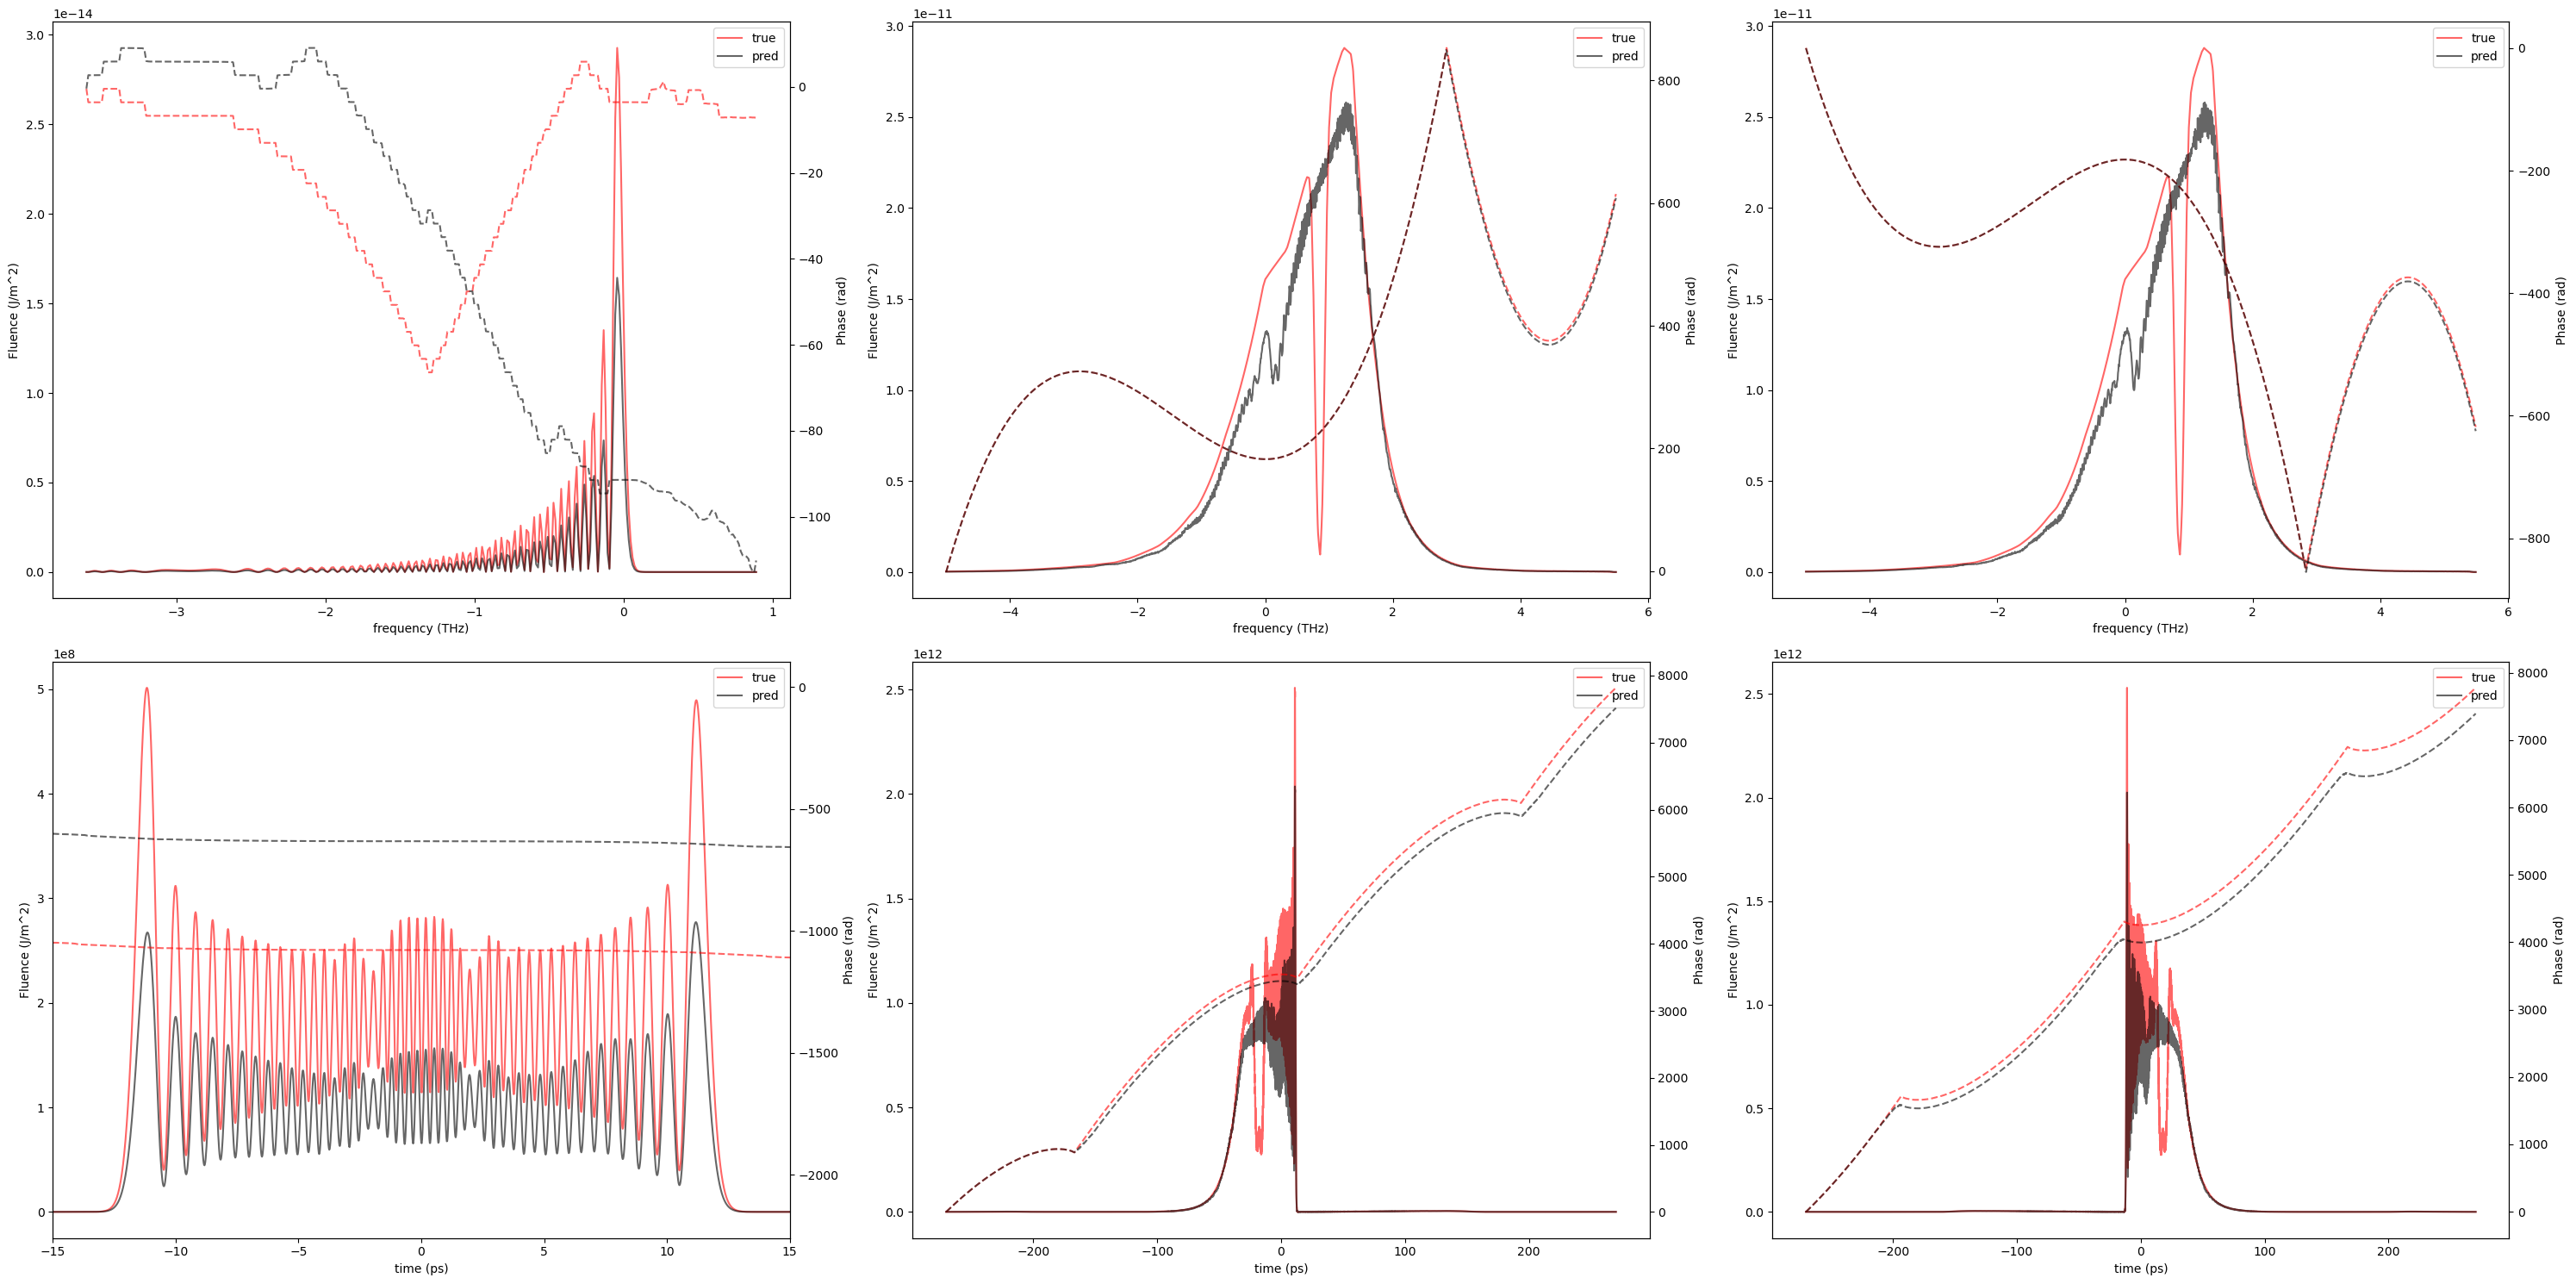

<Figure size 640x480 with 0 Axes>

In [35]:
do_analysis(model_dir, data_dir, model_save_name, file_idx, sample_idx, ".", crystal_length)